In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def create_corpus(docs):
    """Tạo corpus từ danh sách văn bản"""
    processed_docs = [preprocess(doc) for doc in docs]
    vocabulary = sorted(set(word for doc in processed_docs for word in doc))
    return processed_docs, vocabulary

def preprocess(text):
    text = text.lower()  # Chuyển về chữ thường
    words = text.split()  # Tách từ
    return words

def compute_tf(word_list, vocabulary):
    """Tính TF (Term Frequency)"""
    word_count = {}
    for word in word_list:
        word_count[word] = word_count.get(word, 0) + 1
    tf_vector = np.array([word_count[word] / len(word_list) if word in word_count else 0 for word in vocabulary])
    return tf_vector

def compute_idf(docs, vocabulary):
    """Tính IDF (Inverse Document Frequency)"""
    num_docs = len(docs)
    idf_vector = np.array([
        np.log((num_docs + 1) / (1 + sum(1 for doc in docs if word in doc))) + 1
        for word in vocabulary
    ])
    return idf_vector

def compute_tf_idf(docs):
    """Tính ma trận TF-IDF"""
    # Tạo corpus
    processed_docs, vocabulary = create_corpus(docs)

    # Tính TF và IDF
    tf_matrix = np.array([compute_tf(doc, vocabulary) for doc in processed_docs])
    idf_vector = compute_idf(processed_docs, vocabulary)

    # Tính TF-IDF
    tf_idf_matrix = tf_matrix * idf_vector  # Nhân từng phần tử theo chiều dọc
    return tf_idf_matrix

def cosine_similarity(vec1, vec2):
    """Tính độ tương đồng cosine giữa hai vector"""
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2) if norm1 * norm2 != 0 else 0

def check_plagiarism_all(docs):
    """Tính độ tương đồng giữa tất cả các cặp văn bản"""
    tf_idf_matrix = compute_tf_idf(docs)
    num_docs = len(docs)

    similarity_matrix = np.zeros((num_docs, num_docs))

    for i in range(num_docs):
        for j in range(num_docs):
            similarity_matrix[i, j] = cosine_similarity(tf_idf_matrix[i], tf_idf_matrix[j])

    return similarity_matrix


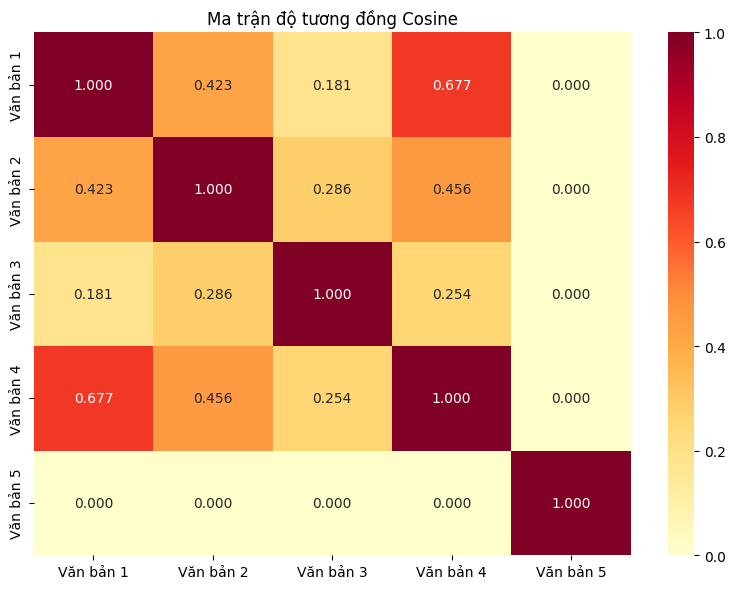

In [ ]:
!pip install mysql-connector-python

In [ ]:
# Kết nối với MySQL database
import mysql.connector
from datetime import datetime

def connect_to_mysql():
    """Tạo kết nối đến MySQL database"""
    try:
        ## Thông số kết nối đến database
        connection = mysql.connector.connect(
            host="localhost",
            user="root",
            password="Nguyen@1997",
            database="plagiarism_db"
        )
        return connection
    except mysql.connector.Error as err:
        print(f"Lỗi kết nối: {err}")
        return None



In [ ]:
def create_database_tables():
    """Tạo các bảng cần thiết trong database"""
    connection = connect_to_mysql()
    if connection:
        try:
            cursor = connection.cursor()


            # Bảng documents - lưu trữ văn bản
            cursor.execute("""
                CREATE TABLE IF NOT EXISTS documents (
                    doc_id INT AUTO_INCREMENT PRIMARY KEY,
                    title VARCHAR(200) NOT NULL,
                    content TEXT NOT NULL,
                    upload_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                    last_modified TIMESTAMP DEFAULT CURRENT_TIMESTAMP ON UPDATE CURRENT_TIMESTAMP
                )
            """)

            # Bảng similarity_scores - lưu kết quả so sánh
            cursor.execute("""
                CREATE TABLE IF NOT EXISTS similarity_scores (
                    score_id INT AUTO_INCREMENT PRIMARY KEY,
                    doc1_id INT,
                    doc2_id INT,
                    similarity_score FLOAT,
                    check_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                    FOREIGN KEY (doc1_id) REFERENCES documents(doc_id),
                    FOREIGN KEY (doc2_id) REFERENCES documents(doc_id)
                )
            """)

            # Bảng plagiarism_reports - lưu báo cáo đạo văn
            cursor.execute("""
                CREATE TABLE IF NOT EXISTS plagiarism_reports (
                    report_id INT AUTO_INCREMENT PRIMARY KEY,
                    doc_id INT,
                    report_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                    status ENUM('pending', 'reviewed', 'confirmed', 'rejected') DEFAULT 'pending',
                    reviewer_notes TEXT,
                    FOREIGN KEY (doc_id) REFERENCES documents(doc_id)
                )
            """)

            # Bảng document_metadata - lưu metadata của văn bản
            cursor.execute("""
                CREATE TABLE IF NOT EXISTS document_metadata (
                    metadata_id INT AUTO_INCREMENT PRIMARY KEY,
                    doc_id INT,
                    word_count INT,
                    language VARCHAR(50),
                    category VARCHAR(100),
                    keywords TEXT,
                    FOREIGN KEY (doc_id) REFERENCES documents(doc_id)
                )
            """)

            connection.commit()
            print("Đã tạo các bảng thành công")

        except mysql.connector.Error as err:
            print(f"Lỗi: {err}")
        finally:
            cursor.close()
            connection.close()

def save_document(user_id, title, content):
    """Lưu văn bản mới vào database"""
    connection = connect_to_mysql()
    if connection:
        try:
            cursor = connection.cursor()
            sql = "INSERT INTO documents (user_id, title, content) VALUES (%s, %s, %s)"
            cursor.execute(sql, (user_id, title, content))
            doc_id = cursor.lastrowid

            # Tính và lưu metadata
            word_count = len(content.split())
            sql = "INSERT INTO document_metadata (doc_id, word_count) VALUES (%s, %s)"
            cursor.execute(sql, (doc_id, word_count))

            connection.commit()
            return doc_id
        except mysql.connector.Error as err:
            print(f"Lỗi: {err}")
            return None
        finally:
            cursor.close()
            connection.close()

def save_similarity_result(doc1_id, doc2_id, similarity_score):
    """Lưu kết quả độ tương đồng vào database"""
    connection = connect_to_mysql()
    if connection:
        try:
            cursor = connection.cursor()
            sql = "INSERT INTO similarity_scores (doc1_id, doc2_id, similarity_score) VALUES (%s, %s, %s)"
            cursor.execute(sql, (doc1_id, doc2_id, float(similarity_score)))

            # Tạo báo cáo tự động dựa trên độ tương đồng
            if similarity_score > 0.8:
                status = 'confirmed'  # Độ tương đồng rất cao, đánh dấu là đạo văn
            elif similarity_score > 0.6:
                status = 'reviewed'   # Độ tương đồng đáng ngờ, đã xem xét
            elif similarity_score > 0.4:
                status = 'pending'    # Độ tương đồng trung bình, chờ xem xét
            else:
                status = 'rejected'   # Độ tương đồng thấp, không phải đạo văn

            sql = "INSERT INTO plagiarism_reports (doc_id, status) VALUES (%s, %s)"
            cursor.execute(sql, (doc2_id, status))
            connection.commit()

        except mysql.connector.Error as err:
            print(f"Lỗi: {err}")
        finally:
            cursor.close()
            connection.close()

def get_documents_with_metadata():
    """Lấy danh sách văn bản và metadata từ database"""
    connection = connect_to_mysql()
    documents = []
    if connection:
        try:
            cursor = connection.cursor()
            cursor.execute("""
                SELECT d.doc_id, d.title, d.content, m.word_count, m.language, m.category
                FROM documents d
                LEFT JOIN document_metadata m ON d.doc_id = m.doc_id
            """)
            documents = cursor.fetchall()
        except mysql.connector.Error as err:
            print(f"Lỗi: {err}")
        finally:
            cursor.close()
            connection.close()
    return documents




In [ ]:
# Tạo cấu trúc database
create_database_tables()

# Thêm dữ liệu mẫu
connection = connect_to_mysql()

if connection:
    try:
        cursor = connection.cursor()

        # Thêm văn bản mẫu
        sample_docs = [
            ("Bài luận 1", "Trí tuệ nhân tạo đang phát triển nhanh chóng và tác động lớn đến cuộc sống."),
            ("Bài luận 2", "Trí tuệ nhân tạo đang phát triển mạnh mẽ và ảnh hưởng nhiều đến đời sống con người."),
            ("Bài luận 3", "Trí tuệ nhân tạo rất mạnh mẽ và ảnh hưởng nhiều đến đời sống con người."),
            ("Bài luận 4", "Deep Learning đã mang lại những bước tiến vượt bậc trong lĩnh vực xử lý ngôn ngữ tự nhiên."),
            ("Bài luận 5", "Robotics và tự động hóa đang thay đổi cách chúng ta làm việc trong các nhà máy."),
            ("Bài luận 6", "Internet of Things kết nối hàng tỷ thiết bị thông minh trên toàn cầu."),
            ("Bài luận 7", "Blockchain không chỉ dùng cho tiền điện tử mà còn nhiều ứng dụng khác."),
            ("Bài luận 8", "Cloud Computing giúp doanh nghiệp tiết kiệm chi phí và tăng hiệu quả."),
            ("Bài luận 9", "Bảo mật thông tin là thách thức lớn trong kỷ nguyên số."),
            ("Bài luận 10", "5G sẽ tạo ra cuộc cách mạng trong truyền thông di động."),
            ("Bài luận 11", "Big Data đang thay đổi cách chúng ta phân tích và ra quyết định."),
            ("Bài luận 12", "Trí tuệ nhân tạo trong y tế giúp chẩn đoán bệnh chính xác hơn."),
            ("Bài luận 13", "Xe tự lái là tương lai của ngành công nghiệp ô tô."),
            ("Bài luận 14", "Công nghệ thực tế ảo đang cách mạng hóa ngành giáo dục."),
            ("Bài luận 15", "Điện toán lượng tử mở ra khả năng tính toán vượt trội."),
            ("Bài luận 16", "Smart City ứng dụng công nghệ để cải thiện cuộc sống đô thị."),
            ("Bài luận 17", "Năng lượng tái tạo và công nghệ xanh là xu hướng phát triển bền vững."),
            ("Bài luận 18", "Fintech đang thay đổi cách chúng ta quản lý và sử dụng tiền."),
            ("Bài luận 19", "Công nghệ sinh học mở ra cơ hội điều trị bệnh hiệu quả hơn, nhất là ứng dụng trí tuệ nhân tạo trong quá trình phát triển."),
            ("Bài luận 20", "Metaverse tạo ra không gian ảo tương tác đa chiều.")
        ]

        for title, content in sample_docs:
            cursor.execute("INSERT INTO documents (title, content) VALUES (%s, %s)", (title, content))
            doc_id = cursor.lastrowid

            # Thêm metadata
            cursor.execute("""
                INSERT INTO document_metadata (doc_id, word_count, language, category)
                VALUES (%s, %s, %s, %s)
            """, (doc_id, len(content.split()), 'vi', 'essay'))

        connection.commit()
    except mysql.connector.Error as err:
        print(f"Lỗi: {err}")
    finally:
        cursor.close()
        connection.close()


Đã tạo các bảng thành công


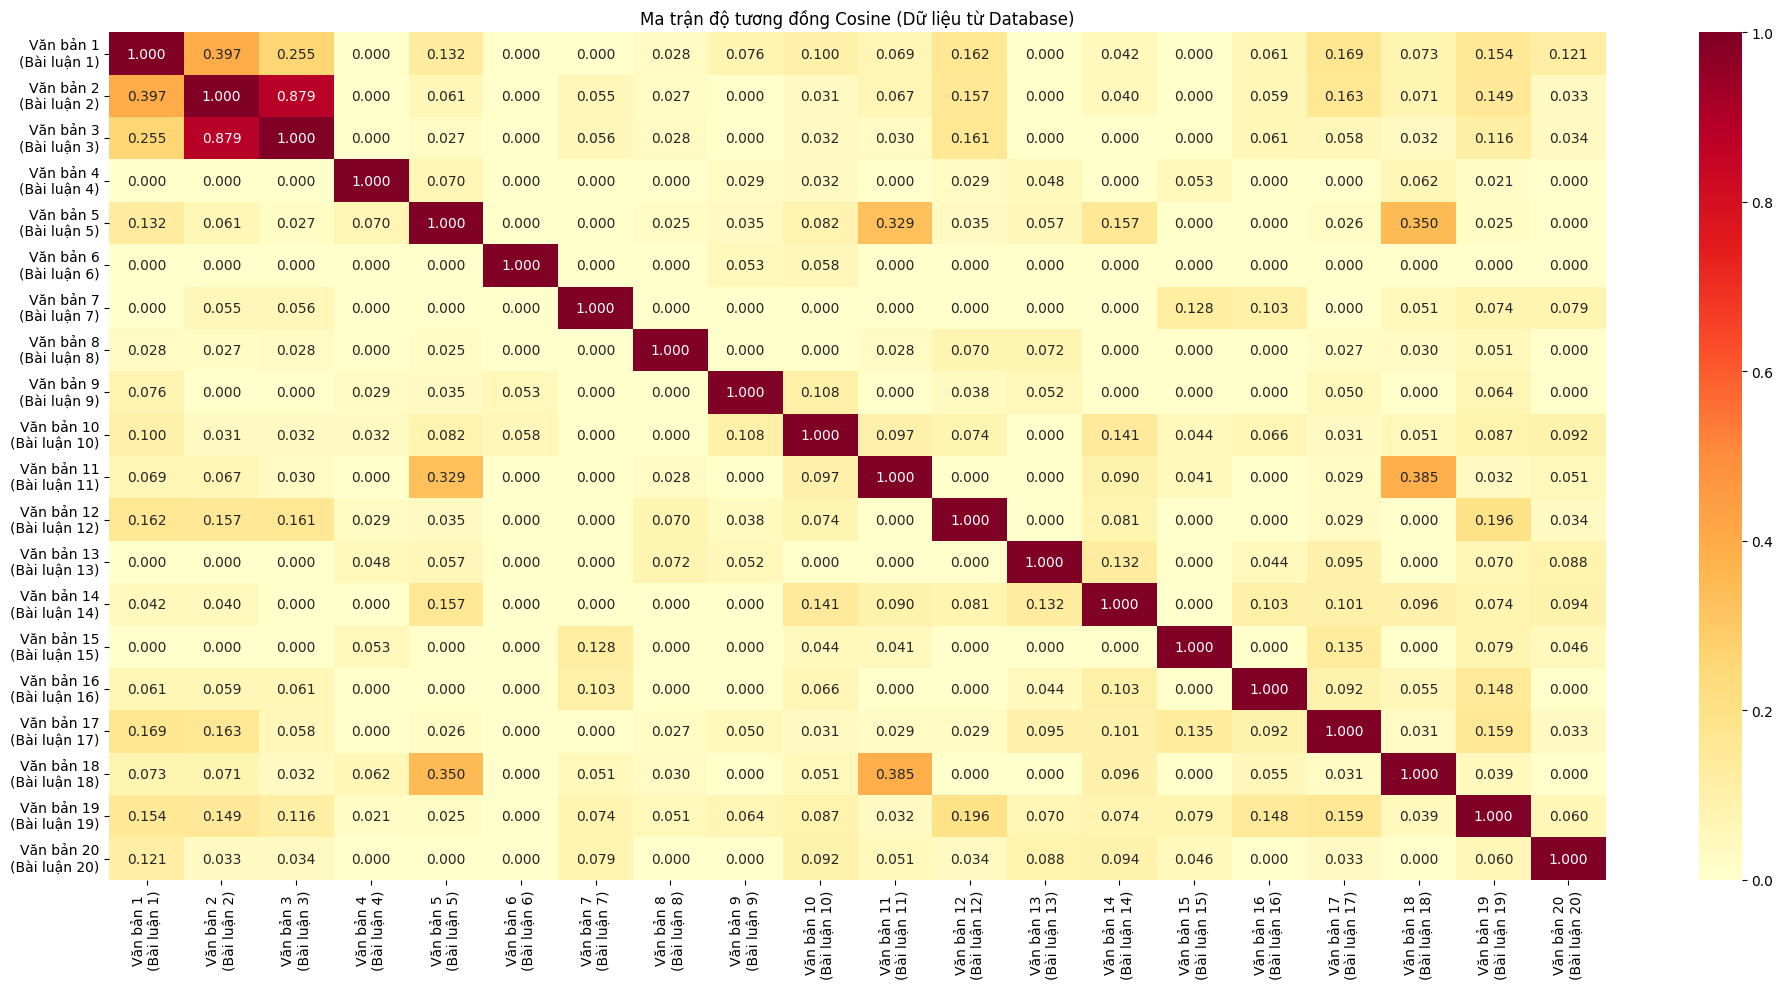

In [ ]:
# Lấy văn bản và metadata
doc_records = get_documents_with_metadata()
if doc_records:
    docs = [record[2] for record in doc_records]  # Lấy phần content
    doc_ids = [record[0] for record in doc_records]  # Lấy doc_id

    # Tính toán độ tương đồng
    similarity_matrix = check_plagiarism_all(docs)

    # Lưu kết quả và tạo báo cáo nếu cần
    for i in range(len(docs)):
        for j in range(i+1, len(docs)):
            save_similarity_result(doc_ids[i], doc_ids[j], similarity_matrix[i][j])

    # Hiển thị kết quả
    plt.figure(figsize=(20, 10))
    sns.heatmap(similarity_matrix,
                annot=True,
                fmt='.3f',
                cmap='YlOrRd',
                xticklabels=[f'Văn bản {i+1}\n({doc_records[i][1]})' for i in range(len(docs))],
                yticklabels=[f'Văn bản {i+1}\n({doc_records[i][1]})' for i in range(len(docs))])

    plt.title('Ma trận độ tương đồng Cosine (Dữ liệu từ Database)')
    plt.tight_layout()
    plt.show()

